# Поиск фото "Со смыслом"

Мы работаетем в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Наш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

### Юридические ограничения

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

    This image is unavailable in your country in compliance with local laws.
    
Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

### Описание данных

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберем либо одну из них, либо объединим их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Наша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

Загрузим датасет с сервера, распакуем и проверим содержание корневого каталога сессии.

In [ ]:
!wget -N https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -uq dsplus_integrated_project_4.zip 
print('-' * 100)
!ls

--2023-02-28 20:10:27--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘dsplus_integrated_project_4.zip’ not modified on server. Omitting download.

----------------------------------------------------------------------------------------------------
dsplus_integrated_project_4.zip  __MACOSX  sample_data	to_upload


Установим дополнительные библиотеки Keras-NLP и Sentence-Transformers.

In [ ]:
!pip install -q --upgrade keras-nlp tensorflow
!pip install -q sentence-transformers

Осуществим импорт библиотек.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords') # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')

from PIL import Image

from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import tensorflow as tf
import keras_nlp

from tqdm import notebook

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import glob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Зададим глобальные переменные. Зафиксируем рандомайзеры.

In [ ]:
PATH = '/content/to_upload'
SEED = 31416
BLOCK = ['teenage', 'baby', 'child', 'teenager', 'girl', 'boy', 'kid']

np.random.seed(SEED)
tf.random.set_seed(SEED)

Прочитаем данные из файлов.

In [ ]:
def read_df(path=PATH) -> pd.DataFrame:

    '''читаем датафреймы из указанной директории'''
    
    df_train = pd.read_csv(Path(path, 'train_dataset.csv'))#.sample(frac=0.1)
    df_crowd = pd.read_csv(Path(path, 'CrowdAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(Path(path, 'ExpertAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(Path(path, 'test_queries.csv'), index_col=[0], sep='|')
    df_images = pd.read_csv(Path(path, 'test_images.csv'), sep='|')
    
    return df_train, df_crowd, df_expert, df_queries, df_images

df_train, df_crowd, df_expert, df_queries, df_images = read_df()

Посмотрим на данные.

In [ ]:
display(df_train.head(), df_crowd.head(), df_expert.head(), df_queries.head(), df_images.head())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

Проверим количество уникальных изображений в обучающем и тестовом наборах.

In [ ]:
print('Количество уникальных фото на трейне:', len(df_train['image'].unique()))
print('Количество уникальных фото на тесте:', len(df_queries['image'].unique()))

Количество уникальных фото на трейне: 1000
Количество уникальных фото на тесте: 100


In [ ]:
print('Количество уникальных запросов на тесте:', df_queries.drop_duplicates().shape[0])

Количество уникальных запросов на тесте: 500


Посмотрим на количество оценок в экспертном и краудсорсинговом наборах.

In [ ]:
print('Количество уникальных сочетаний фото-текст оцененных экспертами:', df_expert.drop_duplicates().shape[0])
print('Количество уникальных сочетаний фото-текст оцененных людьми:', df_crowd.drop_duplicates().shape[0])

Количество уникальных сочетаний фото-текст оцененных экспертами: 5822
Количество уникальных сочетаний фото-текст оцененных людьми: 47830


Проверим, все ли текстовые описания в тестовом наборе совпадают с картинками. В столбце `query_id` зашифрована информация о номере картинки к которой дано описание в столбце `query_text`.

In [ ]:
df_queries[df_queries['query_id'].str[:-2] != df_queries['image']].shape[0]

0

Проверим соответствие текстовых описаний друг другу в обучающем и тестовом наборах.

In [ ]:
print('Уникальных текстовых описаний в трейне:', len(set(df_train['query_text'])))
print('Уникальных текстовых описаний в тесте:', len(set(df_queries['query_text'])))
print('Уникальных текстовых описаний которые есть в обоих наборах:', len(set(df_train['query_text']) & set(df_queries['query_text'])))

Уникальных текстовых описаний в трейне: 977
Уникальных текстовых описаний в тесте: 500
Уникальных текстовых описаний которые есть в обоих наборах: 0


Также проверим не совпадают ли картинки в обучающем и тестовом наборах.

In [ ]:
print('Уникальных картинок в трейне:', len(set(df_train['image'])))
print('Уникальных картинок в тесте:', len(set(df_queries['image'])))
print('Уникальных картинок которые есть в обоих наборах:', len(set(df_train['image']) & set(df_queries['image'])))

Уникальных картинок в трейне: 1000
Уникальных картинок в тесте: 100
Уникальных картинок которые есть в обоих наборах: 0


Познакомимся с изображениями, входящими в датасеты.

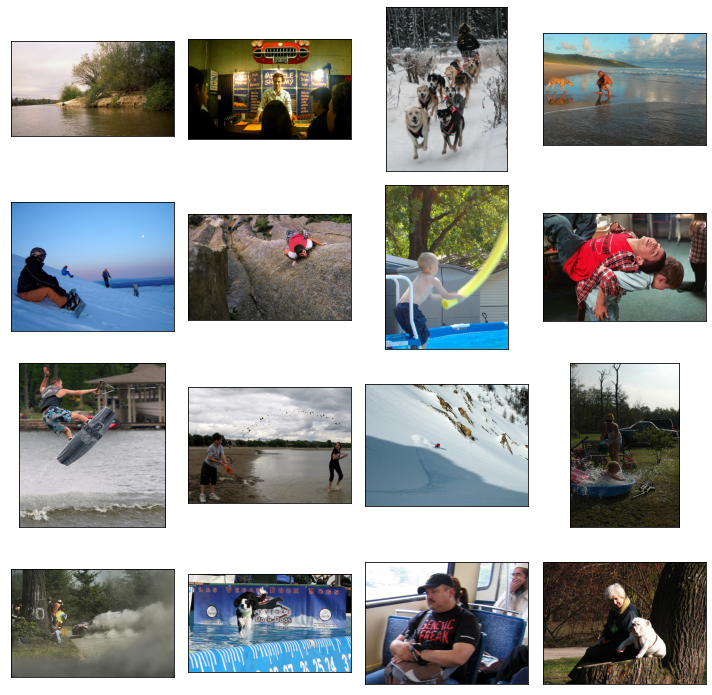

In [ ]:
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_queries['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы

Мы загрузили и ознакомились с данными.

Данный набор данных является частью датасета Flickr30k. В нашем распоряжении 1000 картинок на тест и 100 на трейн. Есть предобработанные файлы с сочетаниями описаний и картинок, для трейна и теста.

Для трейна при этом есть как экспертные оценки соответствия 5822 шт. так и оценки выполненные на краудфайдинговой платформе обычными людьми - 47830 шт, они частично совпадают.

Пересечений между наборами данных для трейна и теста не обнаружено.

На трейне использованы только описания картинок под номером #2, в тесте же к каждой картинке даны по 5 описаний.

Перейдём к аггрегации оценок для получения тестов.

## Аггрегация оценок

Напишем функцию для агрегации оценок экспертов и применим к набору данных.

Если все оценки разные - будем усреднять оценку и приводить к диапазону [0,1], если есть несколько одинаковых оценок - проголосуем большинством.

In [ ]:
def expert_aggregate(row) -> object:

    '''аггрегируем экспертную оценку усреднением ответов и сведением к диапазону [0,1]'''

    if row['first'] != row['second'] != row['third']: #если оценки разные усредняем
        row['expert_score'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3

    else: #если есть одинаковые оценки - аггрегируем голосованием
        row['expert_score'] = (max(set([row['first'], row['second'], row['third']]), key = [row['first'], row['second'], row['third']].count) - 1) / 3

    return row

df_expert = df_expert.apply(expert_aggregate, axis=1)

Поскольку только 2329 пар картинка-текст имеют оценки и людей и экспертов мы объединим оба блока с оценками с флагом `outer`. Таким образом у части пар будут оценки экспертов (как более надёжные), для некоторых оценки людей, для остальных смешанная оценка. Далее мы объединим оценки.

In [ ]:
df_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])

def score_aggregate(row) -> object:

    '''аггрегируем оценки людей и экспертов'''

    if np.isnan(row['expert_score']):
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.7 + row['share_pos'] * 0.3
        
    return row

df_scores = df_scores.apply(score_aggregate, axis=1)

Проверим результат.

In [ ]:
display(df_scores['score'].isna().value_counts())
df_scores['score'].describe()

False    51323
Name: score, dtype: int64

count    51323.000000
mean         0.075967
std          0.208417
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: score, dtype: float64

Добавим цели в наши датасеты.

In [ ]:
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

In [ ]:
to_fill = df_train[df_train['query_text'].notna()]

Заполним пропуски в описании после добавления оценок людей.

In [ ]:
def fill_text(row) -> object:

    '''заполняем пропуски текстов в тренировочном наборе данных'''

    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

df_train = df_train.apply(fill_text, axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


После добавления текстов, оказалось что для части `query_id` нет описаний, поэтому их отбросим.

In [ ]:
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


### Выводы

Выбрали метод и аггрегировали оценки. Объединили оценки с обучающим набором данных, заполнили пропуски, удалили NaN'ы. Цели готовы, перейдём к проверке данных.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для избавления от нелегального контента мы воспользуемся текстовыми описаниями файлов.

Объявим список слов для поиска нелегального контента.

Очистим, токенизируем и лемматизируем текст, чтобы было легче искать запросы связанные с детьми. Отметим в обучающем наборе фото подлежащие блокировке.

In [ ]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text) -> list:

    '''очищаем текст и превращаем в список лемм'''

    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматирзируем слова

    return text

def cleaning(row) -> object:

    '''отмечаем тексты для блокирования'''

    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BLOCK]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [ ]:
%time df_train = df_train.apply(cleaning, axis=1)

CPU times: user 57.9 s, sys: 333 ms, total: 58.3 s
Wall time: 1min


Просмотрим какие тексты оказались заблокированны.

In [ ]:
print(df_train[df_train['to_block'] == 1]['query_text'].sample(10).unique())

['Three children in a black dog kennel .'
 'A woman and a naked child wade into the ocean .'
 'A little girl has dunked her head in a bowl of water .'
 "A picture of Albert Einstein on a white bear statue , with a little boy standing under the bear statue 's face ."
 'A young girl plays in fountain water .'
 'Three boys play around a fountain in an office building courtyard .'
 'Two girls walking down the street .'
 'A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind .'
 "A young girl falls asleep in her father 's arms while seated on an airplane ."
 'A young girl in a white dress watches bubbles while a woman and girl toddler observe .']


Также посмотрим на случайные картинки которые попали под правило блокировки. Для поиска картинок воспользуемся тем что поле `query_id` таблицы `df_train` содержит закодированное имя картинки соответствующей этому описанию. 

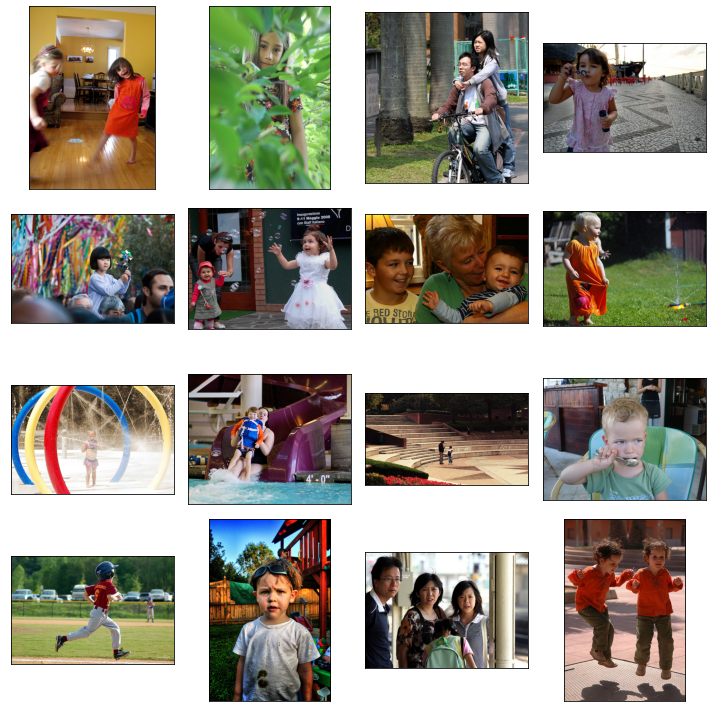

In [ ]:
samples = list(df_train[df_train['to_block'] == 1]['query_id'].sample(16))
samples = [i[:-2] for i in samples]

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Похоже что мы верно отметили фотографии. Удалим строки с фото с детьми из набора данных.

In [ ]:
df_train.drop(df_train[df_train['to_block'] == 1].index, inplace=True, errors='ignore')
df_train.drop(columns='to_block', inplace=True, errors='ignore')
df_train.reset_index(inplace=True, drop=True)

Проверим полученные датасеты.

In [ ]:
display(df_train.head(), df_queries.head())
df_train.info()
print('-' * 100)
df_queries.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
1  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
2   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
3   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
4   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                        query_text     score  
0  A man sleeps under a blanket on a city street .  0.000000  
1  A man sleeps under a blanket on a city street .  0.333333  
2  A man sleeps under a blanket on a city street .  0.233333  
3  A man sleeps under a blanket on a city street .  0.333333  
4  A man sleeps under a blanket on a city street .  0.000000

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36125 entries, 0 to 36124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       36125 non-null  object 
 1   query_id    36125 non-null  object 
 2   query_text  36125 non-null  object 
 3   score       36125 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


### Выводы

Мы проверили данные и исключили из обучения все описания содержащие запрещённую информацию. Перейдём к векторизации изображений.

## Векторизация изображений

Обратимся к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Возьмём архитектуру ResNet-50, посмотрим на слои и исключим полносвязные слои, которые отвечают за конечное предсказание. При этом загрузим модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Напишем функции загрузчиков изображений.

In [ ]:
def load_train(path=PATH) -> ImageDataGenerator:
    
    '''загрузчик данных для обучения'''
    
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=Path(path, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)
    
    return train_gen_flow

Проверим выдачу полученного генератора.

Found 36125 validated image filenames.


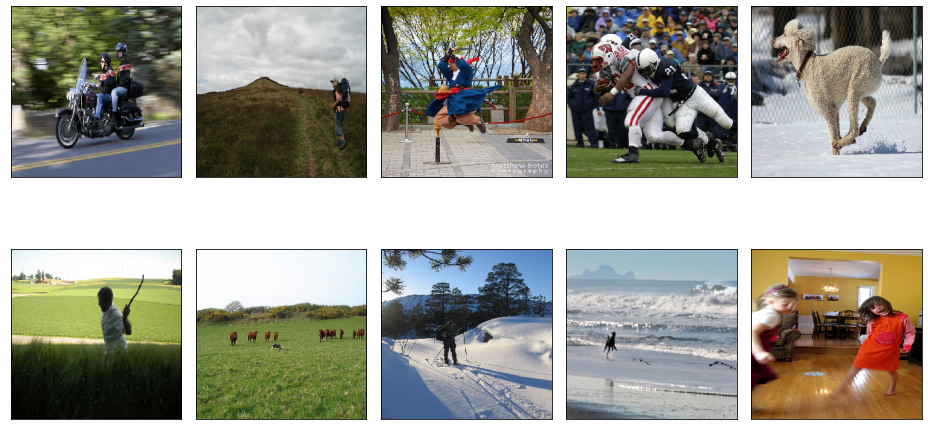

In [ ]:
flow_train = load_train()
features, target = next(flow_train)

fig = plt.figure(figsize=(13,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

В набор попали фотографии с детьми, т.к. в строках с низкой оценкой есть сравнения с такими фотографиями.

Объявим модель.

In [ ]:
def create_model(input_shape=(256, 256, 3)):
    
    '''задаём архитектуру сети'''
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

Получим эмбеддинги наших картинок.

In [ ]:
def vectorize_pictures(model, train_data):
    
    '''превращаем данные в вектор'''
    
    predictions = model.predict(train_data)
    
    return predictions

In [ ]:
%%time

pict_embeds = vectorize_pictures(create_model(), load_train())

94765736/94765736 [==============================] - 5s 0us/step
Found 36125 validated image filenames.
2258/2258 [==============================] - 305s 133ms/step
CPU times: user 6min 37s, sys: 7.52 s, total: 6min 44s
Wall time: 5min 18s


In [ ]:
pict_embeds.shape

(36125, 2048)

### Выводы

Получили векторизированные картинки, теперь перейдём к текстам.

## Векторизация текстов

Следующий этап — векторизация текстов. Для векторизации тектов применим трансформер BERT из библиоетки Keras-NLP.

Загрузим трансформер BERT base cased EN без классифицирующей головы.

In [ ]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

433474808/433474808 [==============================] - 23s 0us/step


Загрузим препроцессор для нашего трансформера.

In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

213450/213450 [==============================] - 0s 2us/step


Напишем функцию для получения эмбеддингов.

In [ ]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0) -> np.array:
    
    '''преобразуем тексты в словарь токенов, масок и паддингов'''

    embeddings = []
    tokenized = preprocessor(data)

    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):
        
            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
            
            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types, 
                    'padding_mask' : mask}
                    
            batch_embeddings = model.predict(batch, verbose=verbose)
            
            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):
        
            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
            
            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types, 
                    'padding_mask' : mask}
                    
            batch_embeddings = model.predict(batch, verbose=verbose)
            
            embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

Преобразуем наши тексты для подачи в функцию.

In [ ]:
text = list(df_train['query_text'])

Запустим получение эмбеддингов.

In [ ]:
%%time

text_embeds = vectorize_text(model=bert, data=text)

  0%|          | 0/1129 [00:00<?, ?it/s]

CPU times: user 26min 29s, sys: 36.2 s, total: 27min 5s
Wall time: 35min 20s


In [ ]:
text_embeds.shape

(36125, 768)

### Выводы

Мы загрузили модель BERT base cased EN и получили эмбеддинги наших текстов. Теперь их необходимо объединить.

## 5. Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

In [ ]:
X = np.concatenate((pict_embeds, text_embeds), axis=1)
X.shape

(36125, 2816)

In [ ]:
y = np.array(df_train['score'])
y.shape

(36125,)

Чтобы на каждом эксперименте с моделями не пересчитывать вектора, сохраним данные для последующей быстрой загрузки.

In [ ]:
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

In [ ]:
'''with open('X.pickle', 'rb') as f:
    X = pickle.load(f)
with open('y.pickle', 'rb') as f:
    y = pickle.load(f)
print(X.shape)
print(y.shape)'''

"with open('X.pickle', 'rb') as f:\n    X = pickle.load(f)\nwith open('y.pickle', 'rb') as f:\n    y = pickle.load(f)\nprint(X.shape)\nprint(y.shape)"

### Выводы

Признаки и цели готовы, можно обучать модели.

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом `GroupShuffleSplit` из библиотеки `sklearn.model_selection`.

Сначала получим обучающую и тестовые выборки.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=SEED)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

In [ ]:
X_train, X_test = X[train_indices], X[test_indices]

In [ ]:
y_train, y_test = y[train_indices], y[test_indices]

Отмасштабируем наши данные.

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### LinearRegression

В качестве baseline'а попробуем модель линейной регрессии.

В качестве метрики мы рассматривали коэффициент детерминации r2 (доля дисперсии, объясняемая моделью), но он малоинформативен для нашей задачи. MAPE является хорошей мерой близости, но в случае когда цели близки к нулю может давать завышенные результаты и при этом лучше себя показывает если среди целей есть большой разброс. Лучше будет воспользоваться в качестве метрики MAE или RMSE, при этом RMSE будет активнее реагировать на большие выбросы предсказаниях (т.к. цель и предсказания возводятся в квадрат до вычисления разницы). Остановимся на RMSE.

In [ ]:
%%time
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
score = cross_val_score(
    model, X_train, y_train, groups=df_train['image'].loc[train_indices],
    scoring='neg_root_mean_squared_error',
    cv=GroupShuffleSplit(random_state=SEED)
).mean()
abs(score).round(decimals=3)

CPU times: user 2min 20s, sys: 13.5 s, total: 2min 34s
Wall time: 1min 40s


0.22

Проверим на тесте.

In [ ]:
pred = model.predict(X_test)
mean_squared_error(y_test, pred, squared=False).round(decimals=3)

0.222

### LinearSVR

Попробуем модель на основе метода опорных векторов.

Зададим параметры сетки для перебора в GridSearch.

In [ ]:
model = LinearSVR(random_state=SEED)

param_grid = {
    'loss':['squared_epsilon_insensitive'],
    'C':[1]
}

gs_svr = GridSearchCV(
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=GroupShuffleSplit(n_splits=3, random_state=SEED),
    verbose=1
)

Проведём подбор гиперпараметров.

In [ ]:
%time gs_svr.fit(X_train, y_train, groups=df_train['image'].loc[train_indices])
None

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 3min 29s, sys: 1.56 s, total: 3min 30s
Wall time: 10min 28s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Посмотрим на результат.

In [ ]:
pd.DataFrame(gs_svr.cv_results_)[['param_C', 'param_loss', 'mean_test_score', 'rank_test_score']].round(decimals=3)

param_C                   param_loss  mean_test_score  rank_test_score
0       1  squared_epsilon_insensitive           -0.271                1

Проверим полученную модель на тесте.

In [ ]:
pred = gs_svr.predict(X_test)
mean_absolute_error(y_test, pred).round(decimals=3)

0.192

### NeuralNetwork

Создадим трёхслоёную нейронную сеть.

In [ ]:
X_train.shape

(28786, 2816)

In [ ]:
NN = Sequential()
NN.add(Dense(2816, input_shape=(2816,), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

NN.build()

NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2816)              7932672   
                                                                 
 batch_normalization (BatchN  (None, 2816)             11264     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               721152    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 8,666,369
Trainable params: 8,660,225
No

In [ ]:
NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
    )

Epoch 1/10
900/900 - 10s - loss: 0.2231 - root_mean_squared_error: 0.4724 - val_loss: 0.1051 - val_root_mean_squared_error: 0.3242 - 10s/epoch - 11ms/step
Epoch 2/10
900/900 - 5s - loss: 0.0917 - root_mean_squared_error: 0.3028 - val_loss: 0.0745 - val_root_mean_squared_error: 0.2729 - 5s/epoch - 6ms/step
Epoch 3/10
900/900 - 6s - loss: 0.0697 - root_mean_squared_error: 0.2640 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2515 - 6s/epoch - 7ms/step
Epoch 4/10
900/900 - 5s - loss: 0.0586 - root_mean_squared_error: 0.2420 - val_loss: 0.0612 - val_root_mean_squared_error: 0.2474 - 5s/epoch - 6ms/step
Epoch 5/10
900/900 - 5s - loss: 0.0550 - root_mean_squared_error: 0.2345 - val_loss: 0.0610 - val_root_mean_squared_error: 0.2470 - 5s/epoch - 5ms/step
Epoch 6/10
900/900 - 6s - loss: 0.0525 - root_mean_squared_error: 0.2292 - val_loss: 0.0597 - val_root_mean_squared_error: 0.2444 - 6s/epoch - 7ms/step
Epoch 7/10
900/900 - 5s - loss: 0.0506 - root_mean_squared_error: 0.2249 - val_loss: 

### Выводы

Модели LinearSVR и NN показали схожие результаты. Можем использовать в дальнейшей работе любую из них.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Создадим загрузчик тестовых изображений.

In [ ]:
def load_test(path=PATH) -> ImageDataGenerator:
    
    '''загрузчик данных для тестирования'''
    
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_images,
        directory=Path(path, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)
    
    return train_gen_flow

Получим эмбеддинги тестовых картинок.

In [ ]:
%%time

pict_embeds_test = vectorize_pictures(create_model(), load_test())
pict_embeds_test.shape

Found 100 validated image filenames.
7/7 [==============================] - 3s 199ms/step
CPU times: user 6.32 s, sys: 201 ms, total: 6.52 s
Wall time: 6.34 s


(100, 2048)

Напишем функцию, принимающую на вход текстовое описание и возвращающую 5 картиной с максимальной предсказанной оценкой схожести.

In [ ]:
def get_picture(text) -> None:

    '''Проверяем легальность запроса, получаем наиболее похожие картинки,
    если описание среди оригинальных картинок - добавляем последней верную'''
    
    if [i for i in get_lemmas(text) if i in BLOCK]: #проверяем не нужно ли вывести на экран заглушку
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        text_embed = vectorize_text(model=bert, data=[text], bar=False) #получаем эмбеддинг текста
        X = np.concatenate(( #объединяем вектора тестовых картинок с эмбеддингом текста
            pict_embeds_test,
            np.resize(text_embed, (pict_embeds_test.shape[0],768))),
            axis=1)
        X = scaler.transform(X)
        predictions = NN.predict(X) #получаем предсказания оценок экспертов
        df = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) #добавляем оценки к номерам картинок
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5)) #получили топ 5 имён файлов с картинками
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5)) #получили топ 5 оценок
        
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        
        fig = plt.figure(figsize=(15,5)) #выводим на экран 5 наиболее похожих картинок
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        if text in list(df_queries['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        plt.show()

    return None

Теперь выберем 10 случайных запросов из файла с тестовыми запросами и посмотрим на результаты.

In [ ]:
samples = df_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['A woman and a young girl riding a sled down a snowy hill while standing .',
 'Three riders wearing black jerseys jump their BMX bikes into the air .',
 'A man lies on a blue blanket with a child on his back .',
 'A white dog with beige spots is running through a field .',
 'A dog is wearing jeans and a blue and yellow shirt with a black vehicle in the background .',
 'a red covered boat racing across the water',
 'A black man in a blue shirt stands next to a black man in a red robe .',
 'Two women dressed with scarves over their heads look angrily at the photographer .',
 'Person jumping into the water .',
 'Little brown and white dog running on the sidewalk .']


-------------------- A woman and a young girl riding a sled down a snowy hill while standing . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 3ms/step

-------------------- Three riders wearing black jerseys jump their BMX bikes into the air . --------------------



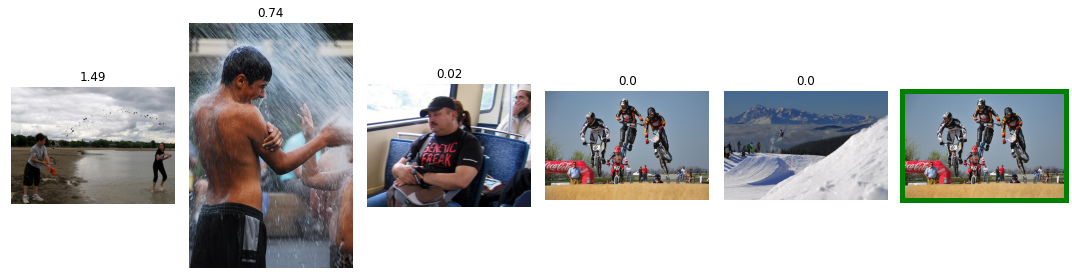


-------------------- A man lies on a blue blanket with a child on his back . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 5ms/step

-------------------- A white dog with beige spots is running through a field . --------------------



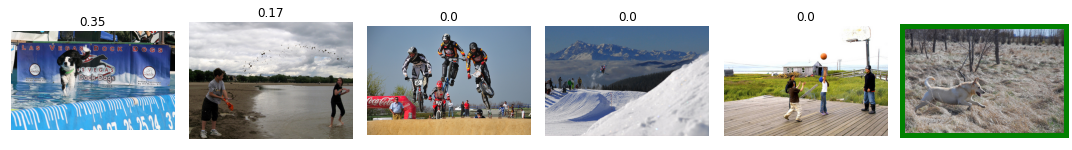

4/4 [==============================] - 0s 5ms/step

-------------------- A dog is wearing jeans and a blue and yellow shirt with a black vehicle in the background . --------------------



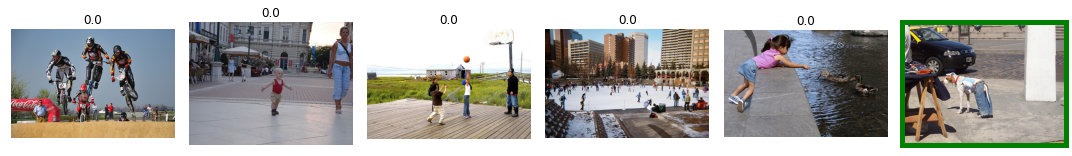

4/4 [==============================] - 0s 4ms/step

-------------------- a red covered boat racing across the water --------------------



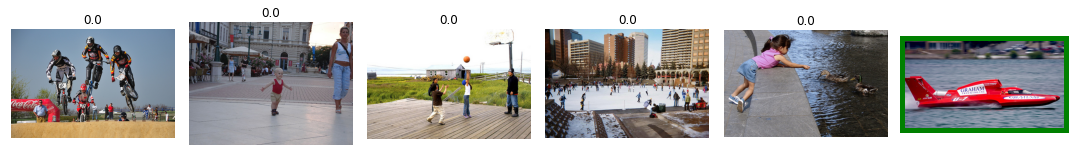

4/4 [==============================] - 0s 6ms/step

-------------------- A black man in a blue shirt stands next to a black man in a red robe . --------------------



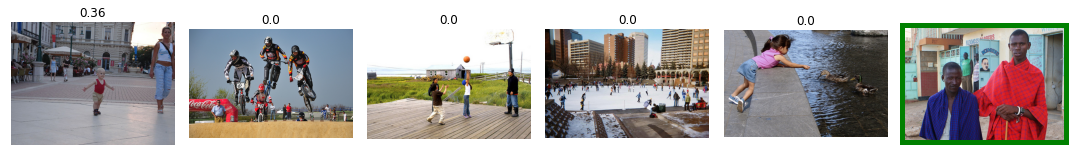

4/4 [==============================] - 0s 3ms/step

-------------------- Two women dressed with scarves over their heads look angrily at the photographer . --------------------



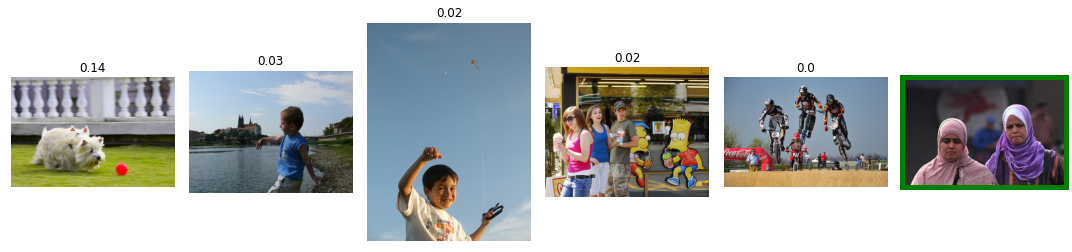

4/4 [==============================] - 0s 4ms/step

-------------------- Person jumping into the water . --------------------



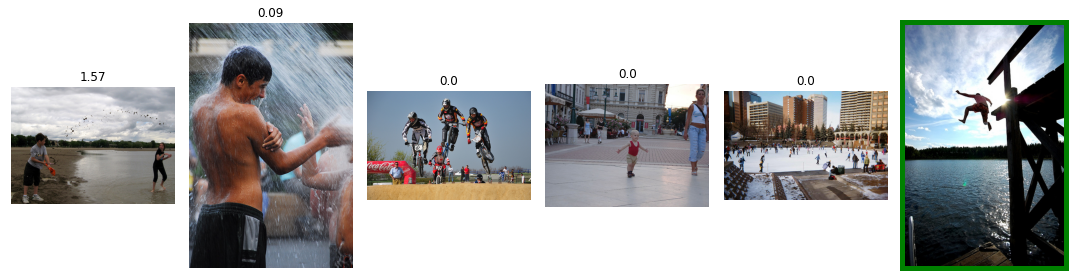

4/4 [==============================] - 0s 4ms/step

-------------------- Little brown and white dog running on the sidewalk . --------------------



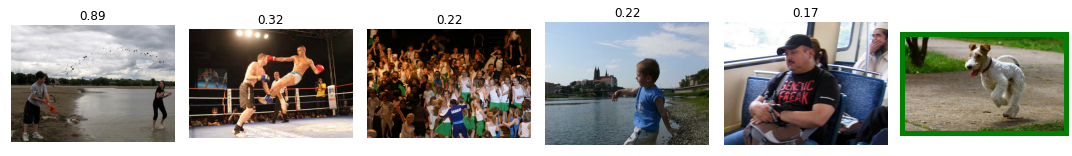

In [ ]:
for text in text_test:
    get_picture(text)

## Заключение

В данной работе мы делали MVP для системы поиска изображений по фотографии.

В ходе работы для векторизации изображений мы использовали сеть ResNet50, а для текстовых эмбеддингов BERT base cased EN.

После объединения признаков и выделения целей (экспертные оценки схожести описания и картинок), мы исследовали три модели для оценки схожести:

   * LinearRegression
   * LinearSVR
   * трёхслойную нейронную сеть

Лучше всего себя показала нейронная сеть, с ней мы провели тесты.

В конце работы мы написали функцию которая по тексту возвращает 5 наиболее похожих картинок и протестировали её на предложенном наборе тестовых картинок.

К сожалению выбранный подход не оправдал себя. Лишь в некоторых случаях в топ5 выдачи попадает верная картинка и, чуть чаще, попадают картинки связанные тематически.

В качестве возможных путей для решения можно предложить использовать полный набор картинок из датасета Flickr30k и смену архитектуры решения.

# Эпилог

В заключительной части мы рассмотрим готовое коробочное решение для задачи поиска картинки по тексту.

Мы будем использовать библиотеку `sentence-transformers` с предобученным нейросетевым триплетом `clip-ViT-B-32` на 400М пар изображение-описание. В данной модели эмбеддинги картинок и текста переводятся в одно векторное пространство, в котором вектора пар картинка-текст будут максимально коллинеарны друг другу.

Для начала объявим и загрузим саму модель.

In [ ]:
model = SentenceTransformer('clip-ViT-B-32')

Далее создадим список с путями к картинкам из тестового набора и получим эмбеддинги этих картинок.

In [ ]:
img_names = list(glob.glob(str(Path(PATH, 'test_images', '*.jpg'))))
img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=16, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Теперь напишем функцию поиска картинки по тексту.

In [ ]:
def search(query) -> None:

    '''Проверяем легальность запроса, получаем наиболее похожие картинки,
    если описание среди оригинальных картинок - добавляем последней верную'''
    
    if [i for i in get_lemmas(query) if i in BLOCK]: #проверяем не нужно ли вывести на экран заглушку
        print('')
        print('-' * 20, query, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False) #получаем эмбеддинг запроса
        # Используем функцию util.semantic_search, которая вычисляет косинусную схожесть
        # между эмбеддингом запроса и всеми картинками из базы.
        # Далее функция возвращает top_k картинок с наивысшим рейтингом
        hits = util.semantic_search(query_emb, img_emb, top_k=5)[0]
        print('')
        print('-' * 20, query, '-' * 20)
        print('')

        fig = plt.figure(figsize=(15,5)) #выводим на экран 5 наиболее похожих картинок
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(hits[i]['score'], 2))
            image = Image.open(img_names[hits[i]['corpus_id']])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        if query in list(df_queries['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == query].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        plt.show()

    return None

Выберем 5 случайных запросов из файла `df_queries`.

In [ ]:
samples = df_queries.sample(5)
queries = list(samples['query_text'])
queries

['A dog wearing jeans and a shirt stands on the sidewalk .',
 'A brown dog and a black dog run into each other in the grass .',
 'A black and white dog with a green collar stands in front of a sign .',
 'A group of women all dressed in red with yellow flower pins .',
 'The brown dog is wearing a black collar .']

Применим функцию поиска и посмотрим на результат.


-------------------- A dog wearing jeans and a shirt stands on the sidewalk . --------------------



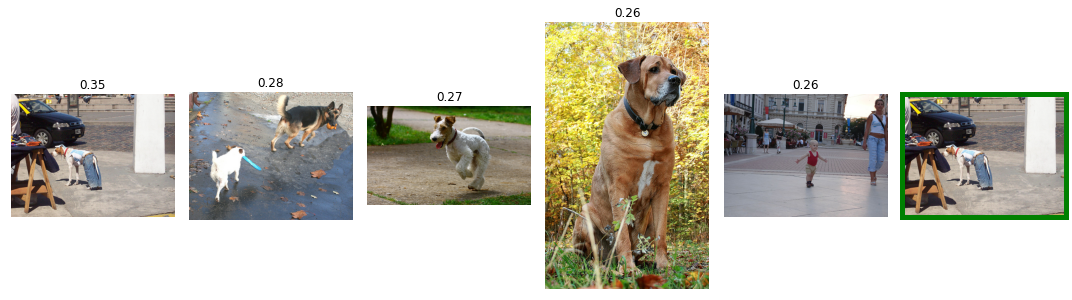


-------------------- A brown dog and a black dog run into each other in the grass . --------------------



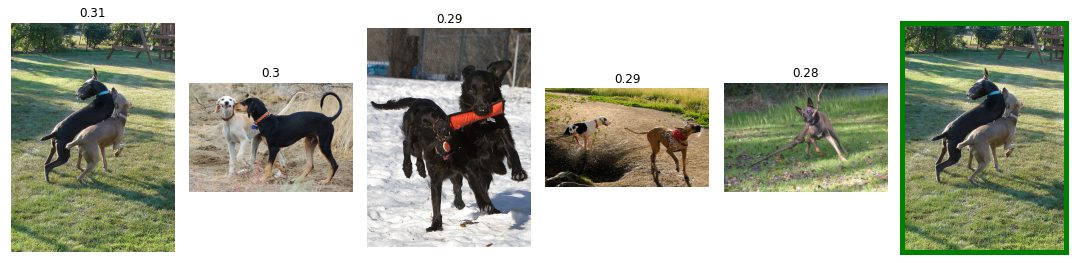


-------------------- A black and white dog with a green collar stands in front of a sign . --------------------



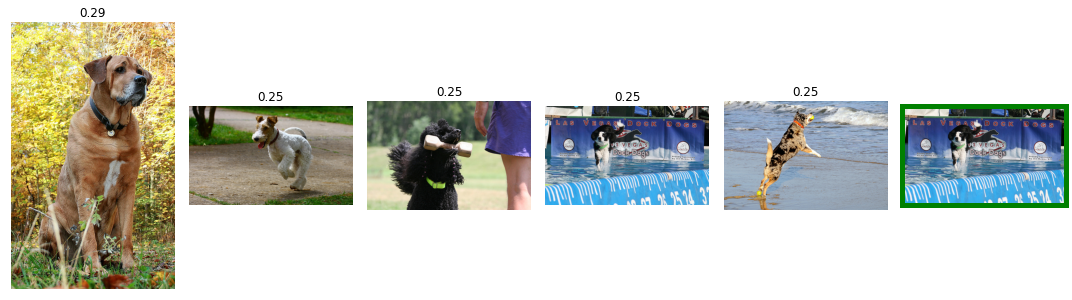


-------------------- A group of women all dressed in red with yellow flower pins . --------------------



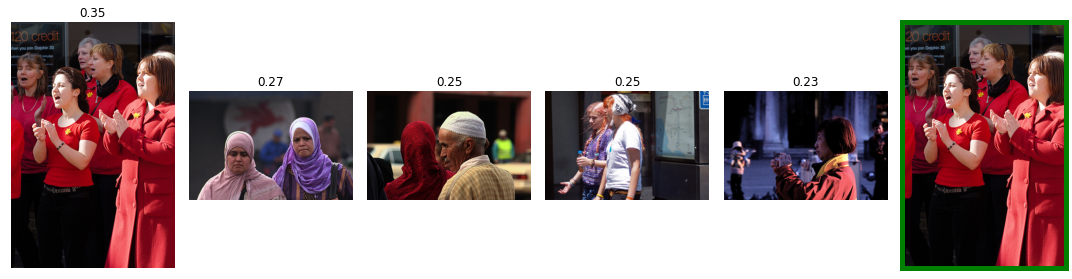


-------------------- The brown dog is wearing a black collar . --------------------



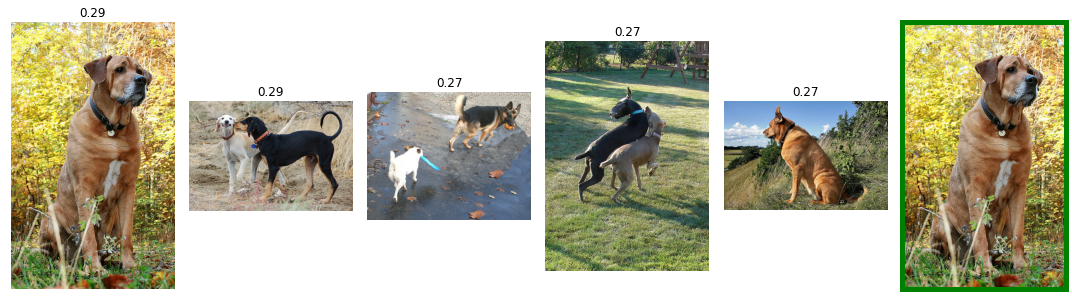

In [ ]:
for query in queries:
    search(query)